# 1. Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
# %config InlineBackend.figure_format = 'svg' 
# plt.style.use('ggplot')

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
SAVE_PATH_FIG = '.\projects_temp-figs'

# 2. Create synthetic data

In [3]:
def my_synthetic_data():
    # Generate a synthetic binary classification dataset
    x, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
    
    # Split the dataset into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    # Train a logistic regression classifier
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    
    # Predict probabilities on the test set
    y_pred = clf.predict_proba(x_test)[:, 1]  # probabilities for the positive class
    
    # The y_test and y_pred can be used to test the plot_roc_and_calculate_auc function
    return y_test, y_pred

y_test, y_pred = my_synthetic_data()

# 3. Visualize ROC-curve with TPR and FPR 

In [4]:
def my_plot_roc_binary(y_true, y_scores, save_path, figure_name):
    """
    Plots the Receiver Operating Characteristic (ROC) curve and calculates the 
    Area Under the Curve (AUC) for a binary classifier.
    
    The function takes two arguments: `y_true`, an array of true binary labels, 
    and `y_scores`, an array of predicted scores/probabilities from the classifier. 
    It calculates the True Positive Rate (TPR) and False Positive Rate (FPR) at 
    various threshold settings derived from the predicted scores. The ROC curve 
    is then plotted with TPR against FPR, and the AUC is calculated using the 
    trapezoidal rule.
    
    Parameters:
    y_true (array-like): True binary labels. Must be the same length as `y_scores`.
    y_scores (array-like): Predicted scores/probabilities for the positive class.
    
    Returns:
    float: The AUC (Area Under Curve) value, a measure of the classifier's performance.
    
    Note:
    This function assumes that the positive class is labeled as '1' and the negative
    class as '0'. The `y_scores` array should contain probabilities or scores that 
    reflect the likelihood of belonging to the positive class.
    """
    # Define the figure name and path
    my_save_path = os.path.join(save_path, figure_name)

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    
    # Sort scores and corresponding true values
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # Temporarily ignore divide by zero warnings
    np.seterr(divide='ignore', invalid='ignore')
    
    # Compute True Positive and False Positive Counts
    tp = np.cumsum(y_true)  # Cumulative sum of true positives
    fp = np.cumsum(1 - y_true)  # Cumulative sum of false positives
    tn = fp[-1] - fp  # True negatives at each threshold
    fn = tp[-1] - tp  # False negatives at each threshold

    # Calculate TPR and FPR
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    # Replace NaNs in FPR with zero
    fpr = np.nan_to_num(fpr)
    tpr = np.nan_to_num(tpr)

    # Restore the default error handling for NumPy
    np.seterr(divide='warn', invalid='warn')
    
    # Calculate AUC using the trapezoidal rule
    roc_auc = np.trapz(tpr, fpr)

    # Plotting ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
    plt.legend(loc="lower right", fontsize=14)

    plt.savefig(my_save_path, format='png', bbox_inches='tight')
    print(f"Plot saved to {save_path} as {figure_name}")
    # plt.gcf().set_dpi(200)
    plt.show()

    return roc_auc


In [5]:
# my_auc = my_plot_roc_binary(y_test, y_pred, SAVE_PATH_FIG, figure_name='my_plot_roc_binary')

# 4. Visualize ROC-curve with sklearn

In [6]:
def plot_roc_skl_binary(y_true, y_scores, save_path, figure_name):
    """
    Plots the Receiver Operating Characteristic (ROC) curve and calculates the
    Area Under the Curve (AUC) for a binary classifier using sklearn's roc_curve 
    and roc_auc_score functions.
    
    This function is designed to work with binary classification models. It takes
    two arguments: `y_true`, an array of true binary labels, and `y_scores`, an 
    array of predicted probabilities or decision function scores from the classifier. 
    It utilizes sklearn's roc_curve to calculate the True Positive Rate (TPR) and 
    False Positive Rate (FPR) at various thresholds, and plots these to produce the ROC curve.
    The AUC is calculated using sklearn's roc_auc_score.
    
    Parameters:
    y_true (array-like): True binary labels. Must be the same length as `y_scores`.
    y_scores (array-like): Predicted probabilities or decision function scores for
                           the positive class. Must be a 1D array.
    
    Returns:
    float: The AUC (Area Under Curve) value, indicating the performance of the classifier.
    
    Note:
    The function assumes a binary classification task where the positive class is labeled as '1'
    and the negative class as '0'. The `y_scores` should contain values that represent the
    likelihood of the positive class, typically ranging between 0 and 1.
    """
    # Define the figure name and path
    my_save_path = os.path.join(save_path, figure_name + '.png')

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Calculate False Positive Rate and True Positive Rate
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Calculate AUC
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plotting ROC Curve
    plt.figure(figsize=(6,4), dpi=300)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-крива (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12, fontweight='bold', color='#333333')
    plt.yticks(fontsize=12, fontweight='bold', color='#333333')
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', color='#333333')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold', color='#333333')
    
    plt.title(f'ROC-крива для {figure_name}', fontsize=16, fontweight='bold')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.legend(loc="lower right", fontsize=14)

    plt.savefig(my_save_path, format='png', bbox_inches='tight')
    print(f"Plot saved to {save_path} as {figure_name}")
    # plt.gcf().set_dpi(200)
    plt.show()

    return roc_auc


Plot saved to .\projects_temp-figs as my_plot_roc_sk


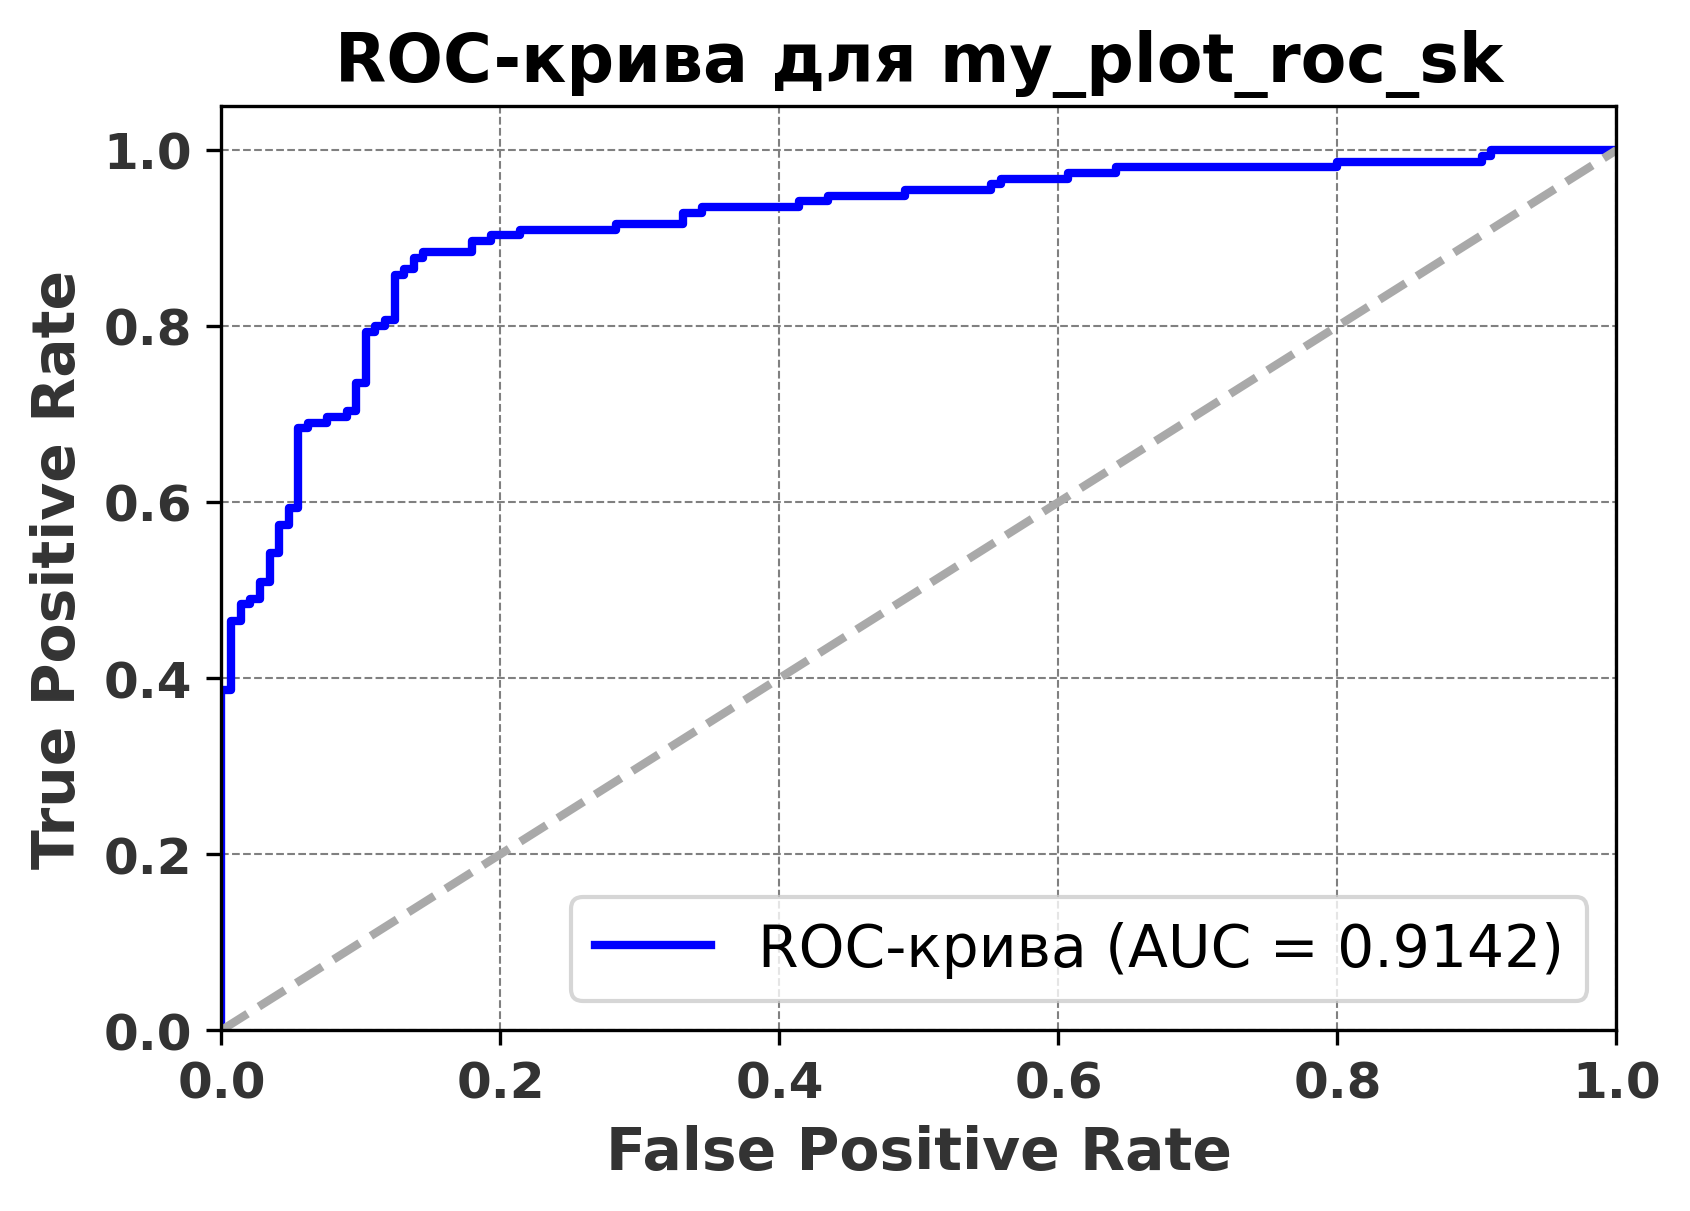

In [7]:
auc_skl = plot_roc_skl_binary(y_test, y_pred, SAVE_PATH_FIG, figure_name='my_plot_roc_sk')

# 5. Extract data from a CSV file

In [8]:
# Load the uploaded CSV file into a pandas DataFrame
dataset_out = 'med_records_results.csv'
folder_out = './projects_outscope'
file_path_out = os.path.join(folder_out, dataset_out)

data_frame = pd.read_csv(file_path_out)

# Extract the two tables from the data frame
y_test_out = data_frame[['y_test']].to_numpy()
y_pred_out = data_frame[['y_pred']].to_numpy()

# Display the first few rows of each table for confirmation
# y_test_out[:5], y_pred_out[:5]

In [9]:
# figure_name_out = 'my_roc_out'
# my_auc_out = plot_roc_skl_binary(y_test_out, y_pred_out, folder_out, figure_name=figure_name_out)

# 6. Transform XLSX to CSV

In [10]:
'''
# Define the input and output folder paths
input_folder_excel = './projects_outscope/outscope_excel'
output_folder_csv = './projects_outscope/outscope_csv'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder_csv):
    os.makedirs(output_folder_csv)

# Loop through each file in the input folder
for file in os.listdir(input_folder_excel):
    # Check if the file is an Excel file
    if file.endswith('.xlsx') or file.endswith('.xls'):
        # Construct the full file path
        input_file_path = os.path.join(input_folder_excel, file)

        # Read the Excel file
        df = pd.read_excel(input_file_path)

        # Construct the output file path (change extension to .csv)
        output_file_path = os.path.join(output_folder_csv, os.path.splitext(file)[0] + '.csv')

        # Save the DataFrame as a CSV file
        df.to_csv(output_file_path, index=False)

        print(f'Converted {file} to CSV and saved in {output_folder_csv}')

print("All Excel files have been converted to CSV.")
'''


'\n# Define the input and output folder paths\ninput_folder_excel = \'./projects_outscope/outscope_excel\'\noutput_folder_csv = \'./projects_outscope/outscope_csv\'\n\n# Create the output folder if it doesn\'t exist\nif not os.path.exists(output_folder_csv):\n    os.makedirs(output_folder_csv)\n\n# Loop through each file in the input folder\nfor file in os.listdir(input_folder_excel):\n    # Check if the file is an Excel file\n    if file.endswith(\'.xlsx\') or file.endswith(\'.xls\'):\n        # Construct the full file path\n        input_file_path = os.path.join(input_folder_excel, file)\n\n        # Read the Excel file\n        df = pd.read_excel(input_file_path)\n\n        # Construct the output file path (change extension to .csv)\n        output_file_path = os.path.join(output_folder_csv, os.path.splitext(file)[0] + \'.csv\')\n\n        # Save the DataFrame as a CSV file\n        df.to_csv(output_file_path, index=False)\n\n        print(f\'Converted {file} to CSV and saved in {ou

# 7. Draw ROC-curves from the CSV files

Plot saved to ./projects_outscope/outscope_figs as Донорство


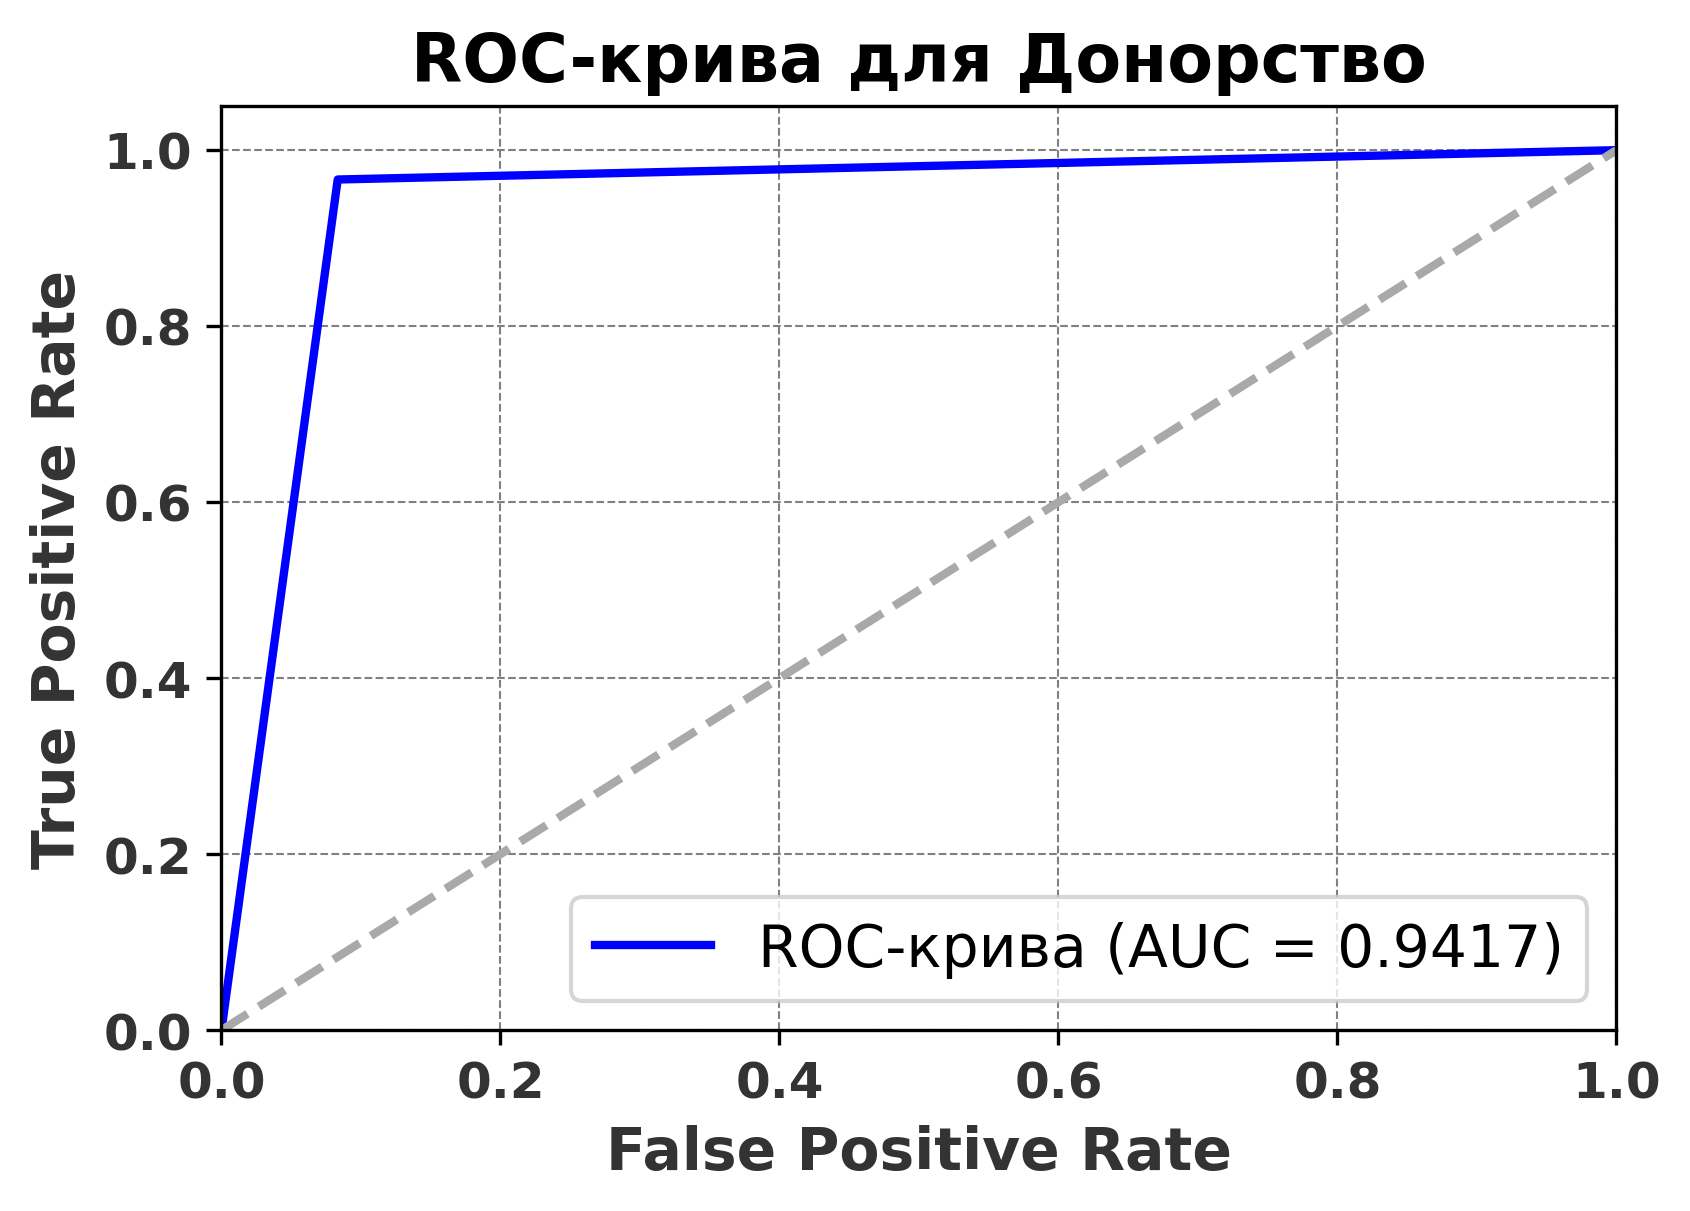

ROC curve for Донорство.csv plotted with AUC: 0.9417
Plot saved to ./projects_outscope/outscope_figs as ЕКЗ


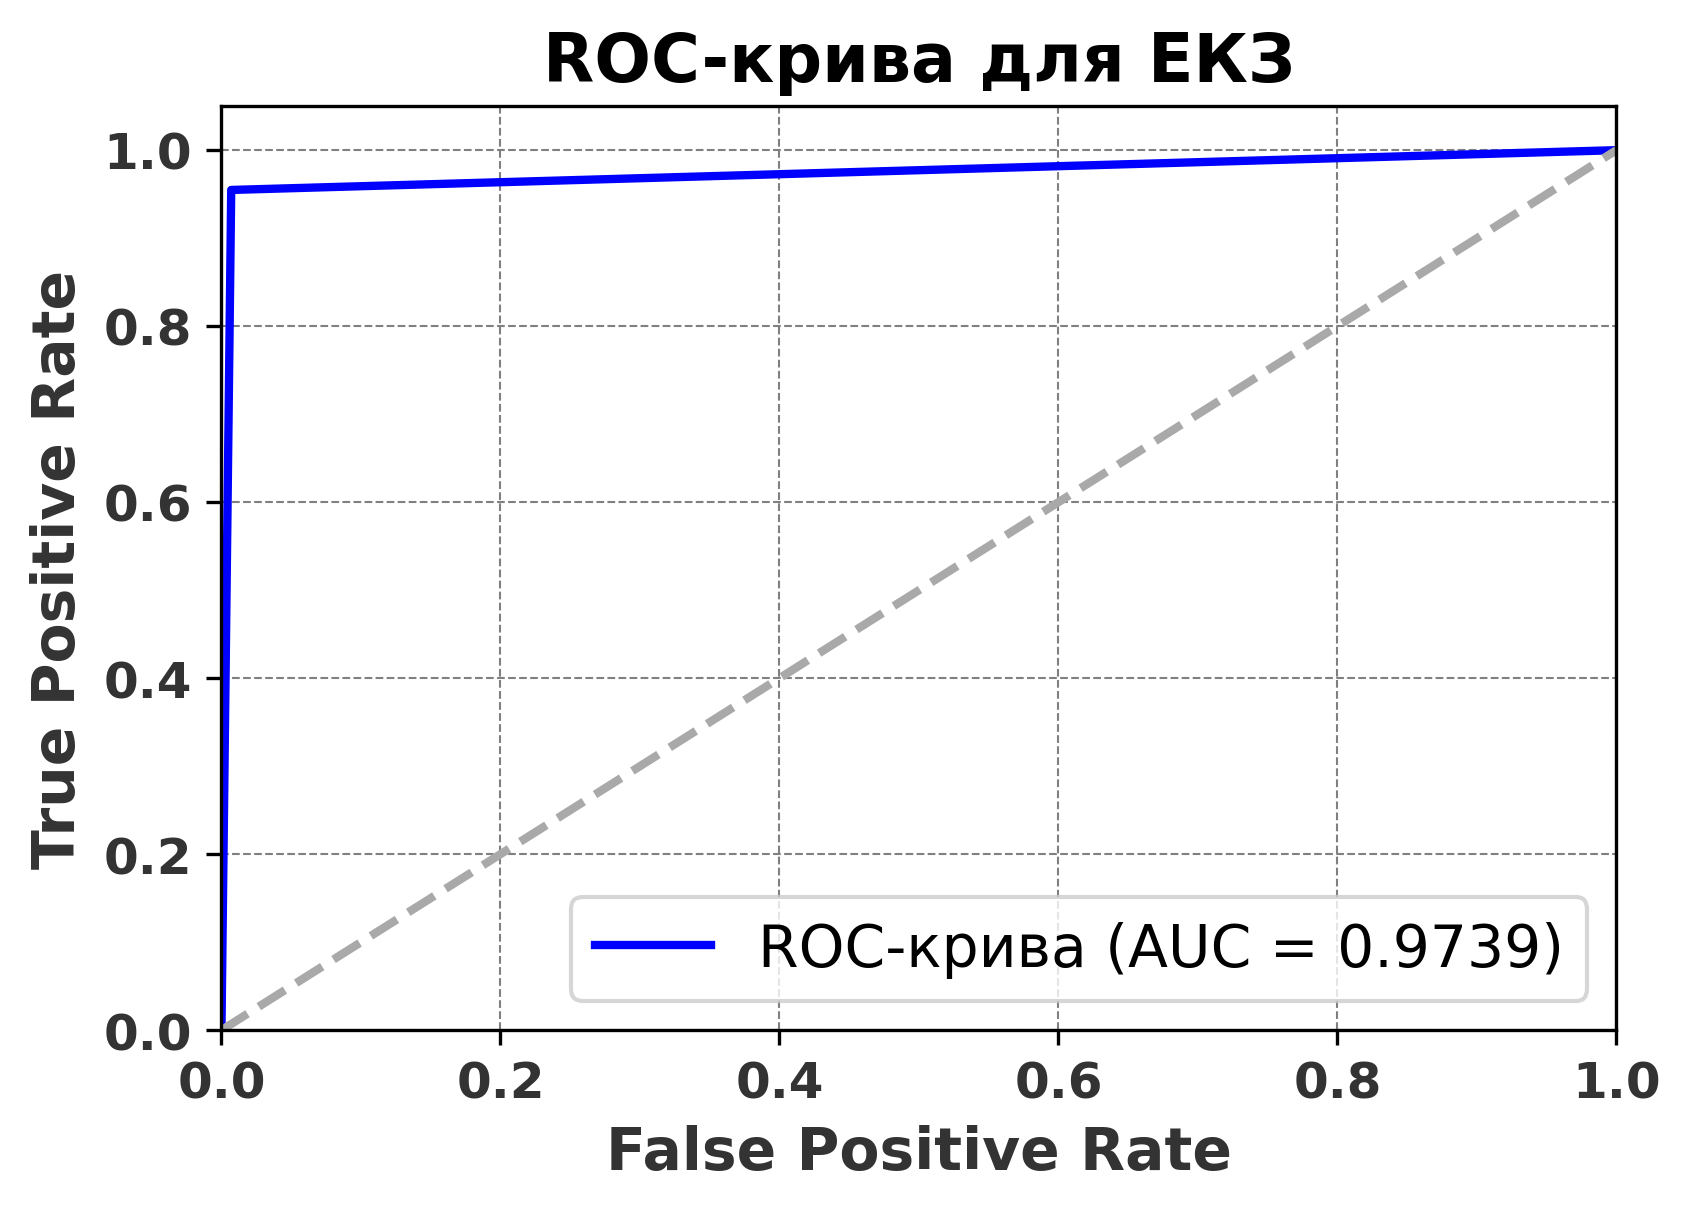

ROC curve for ЕКЗ.csv plotted with AUC: 0.9739
Plot saved to ./projects_outscope/outscope_figs as ЗМП


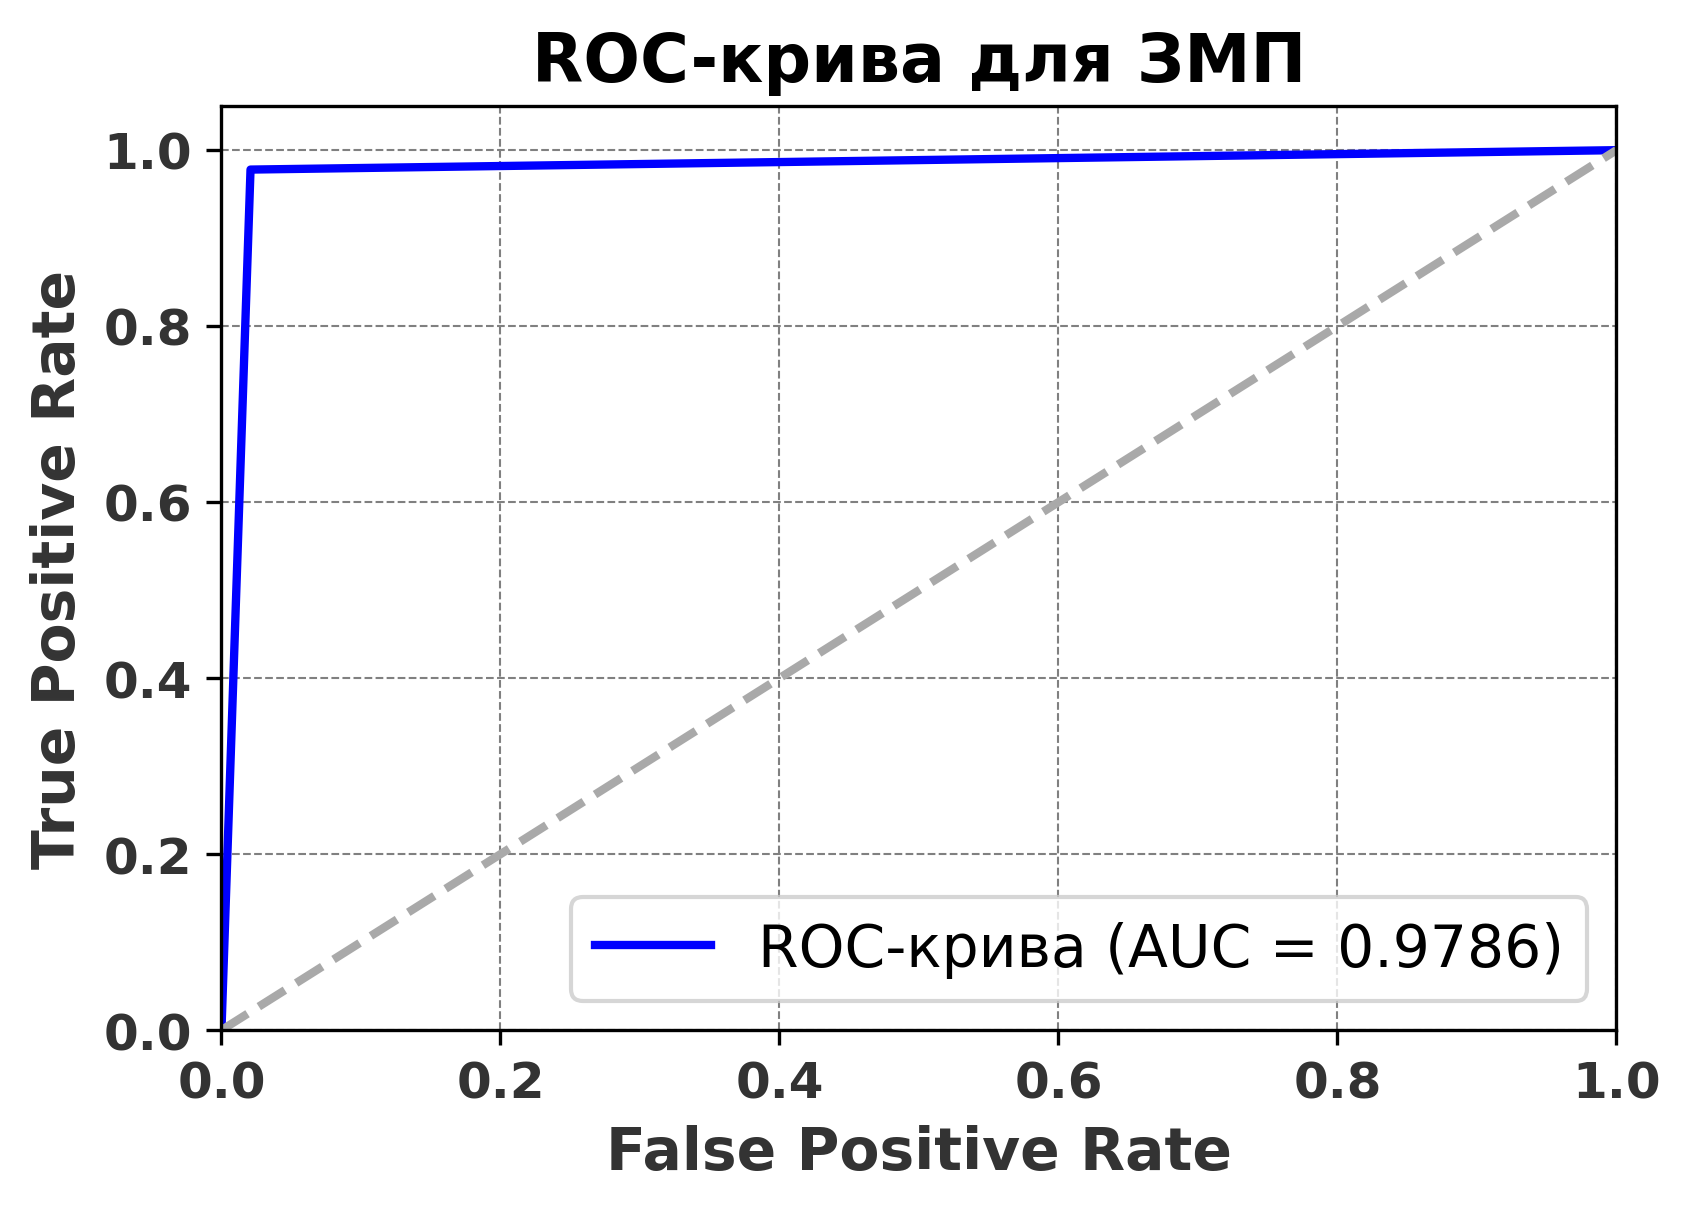

ROC curve for ЗМП.csv plotted with AUC: 0.9786
Plot saved to ./projects_outscope/outscope_figs as Можливість вакцинації


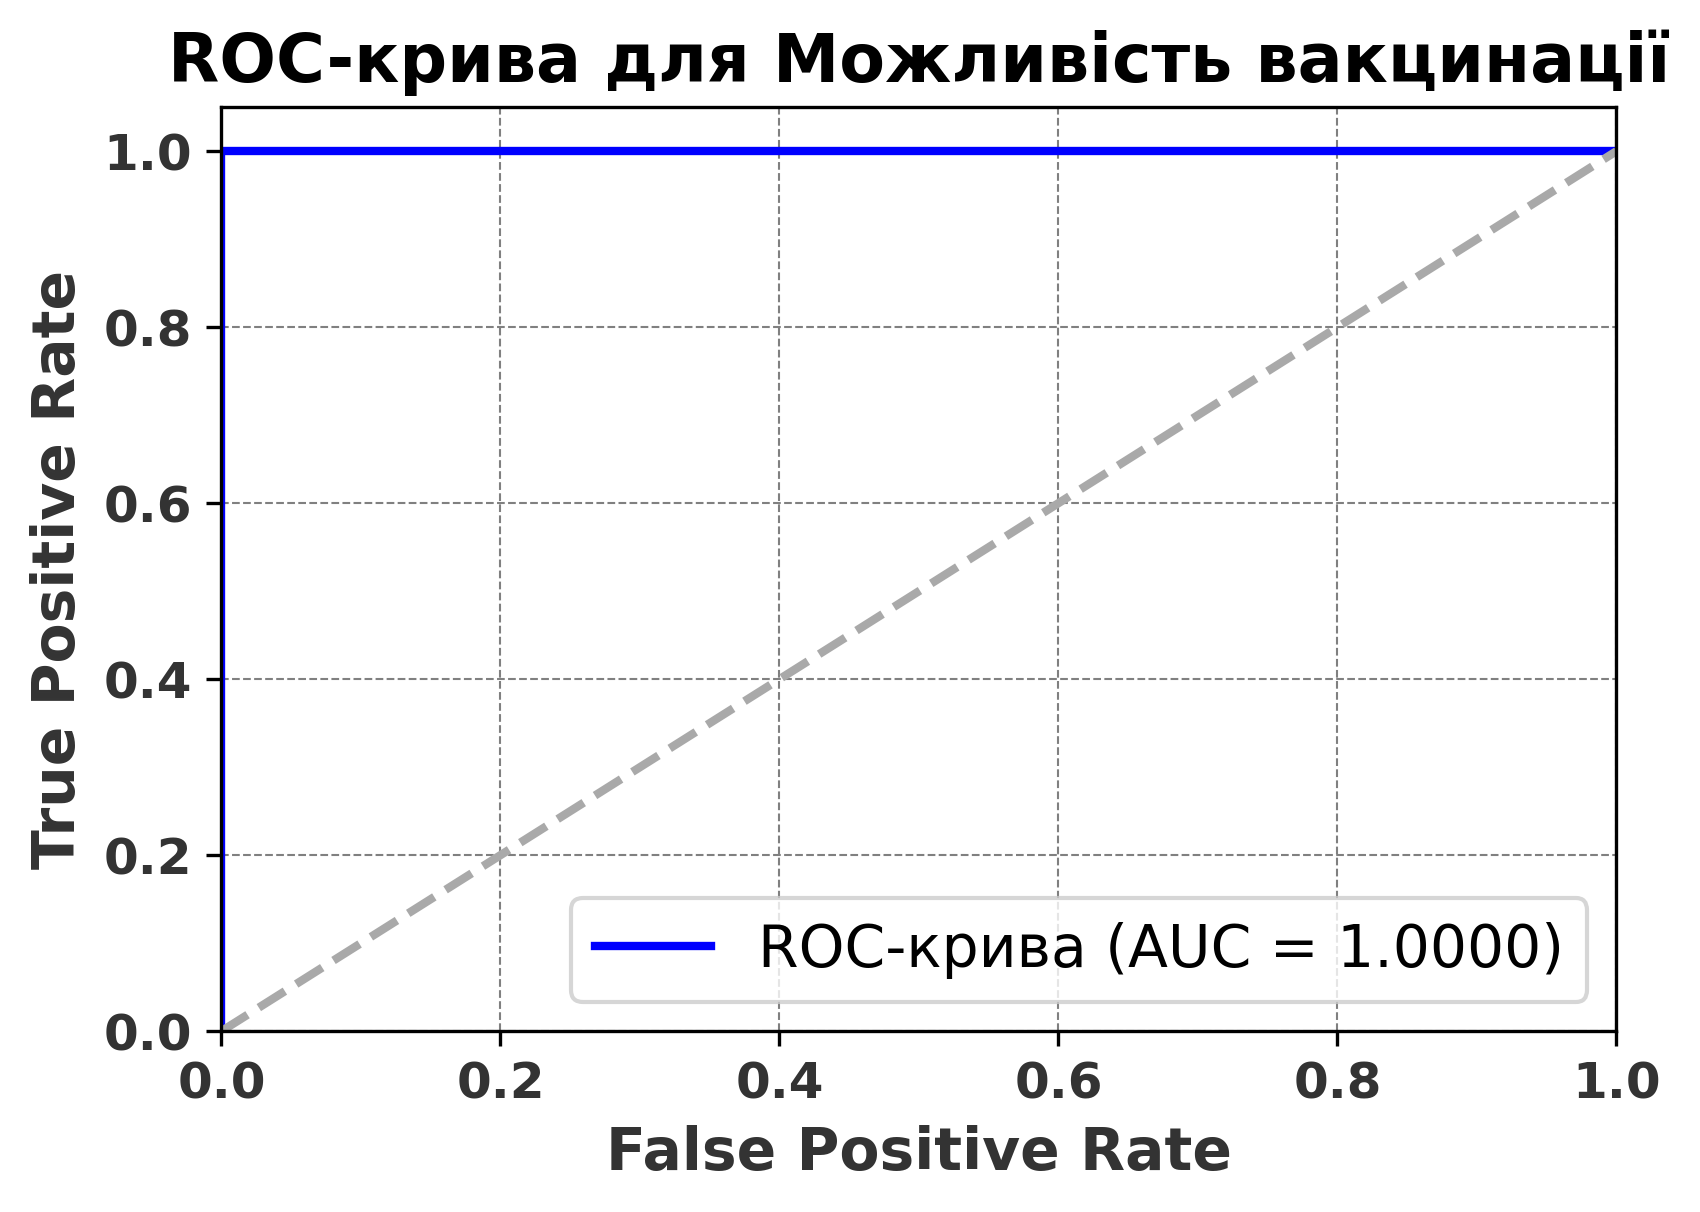

ROC curve for Можливість вакцинації.csv plotted with AUC: 1.0000
Plot saved to ./projects_outscope/outscope_figs as Обов'язковість вакцинації


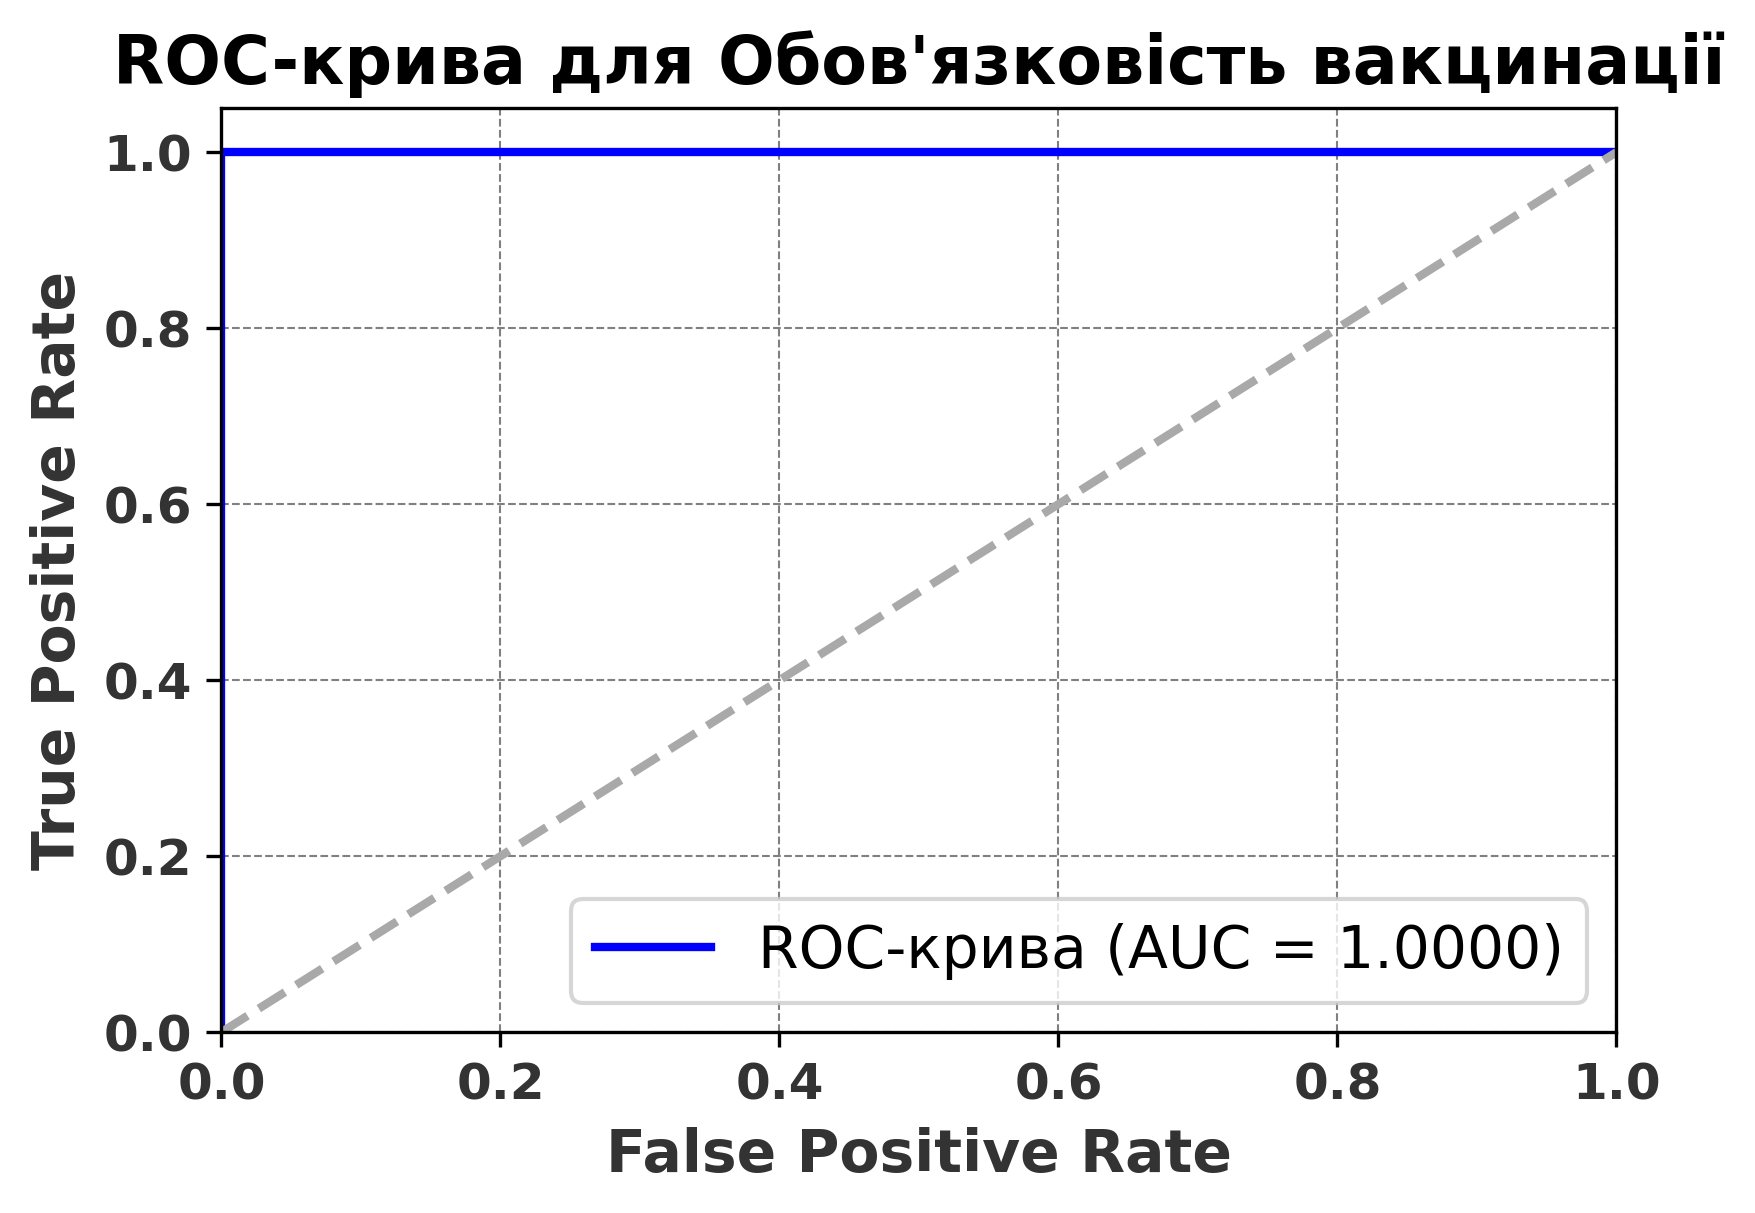

ROC curve for Обов'язковість вакцинації.csv plotted with AUC: 1.0000
Plot saved to ./projects_outscope/outscope_figs as Стоматологія


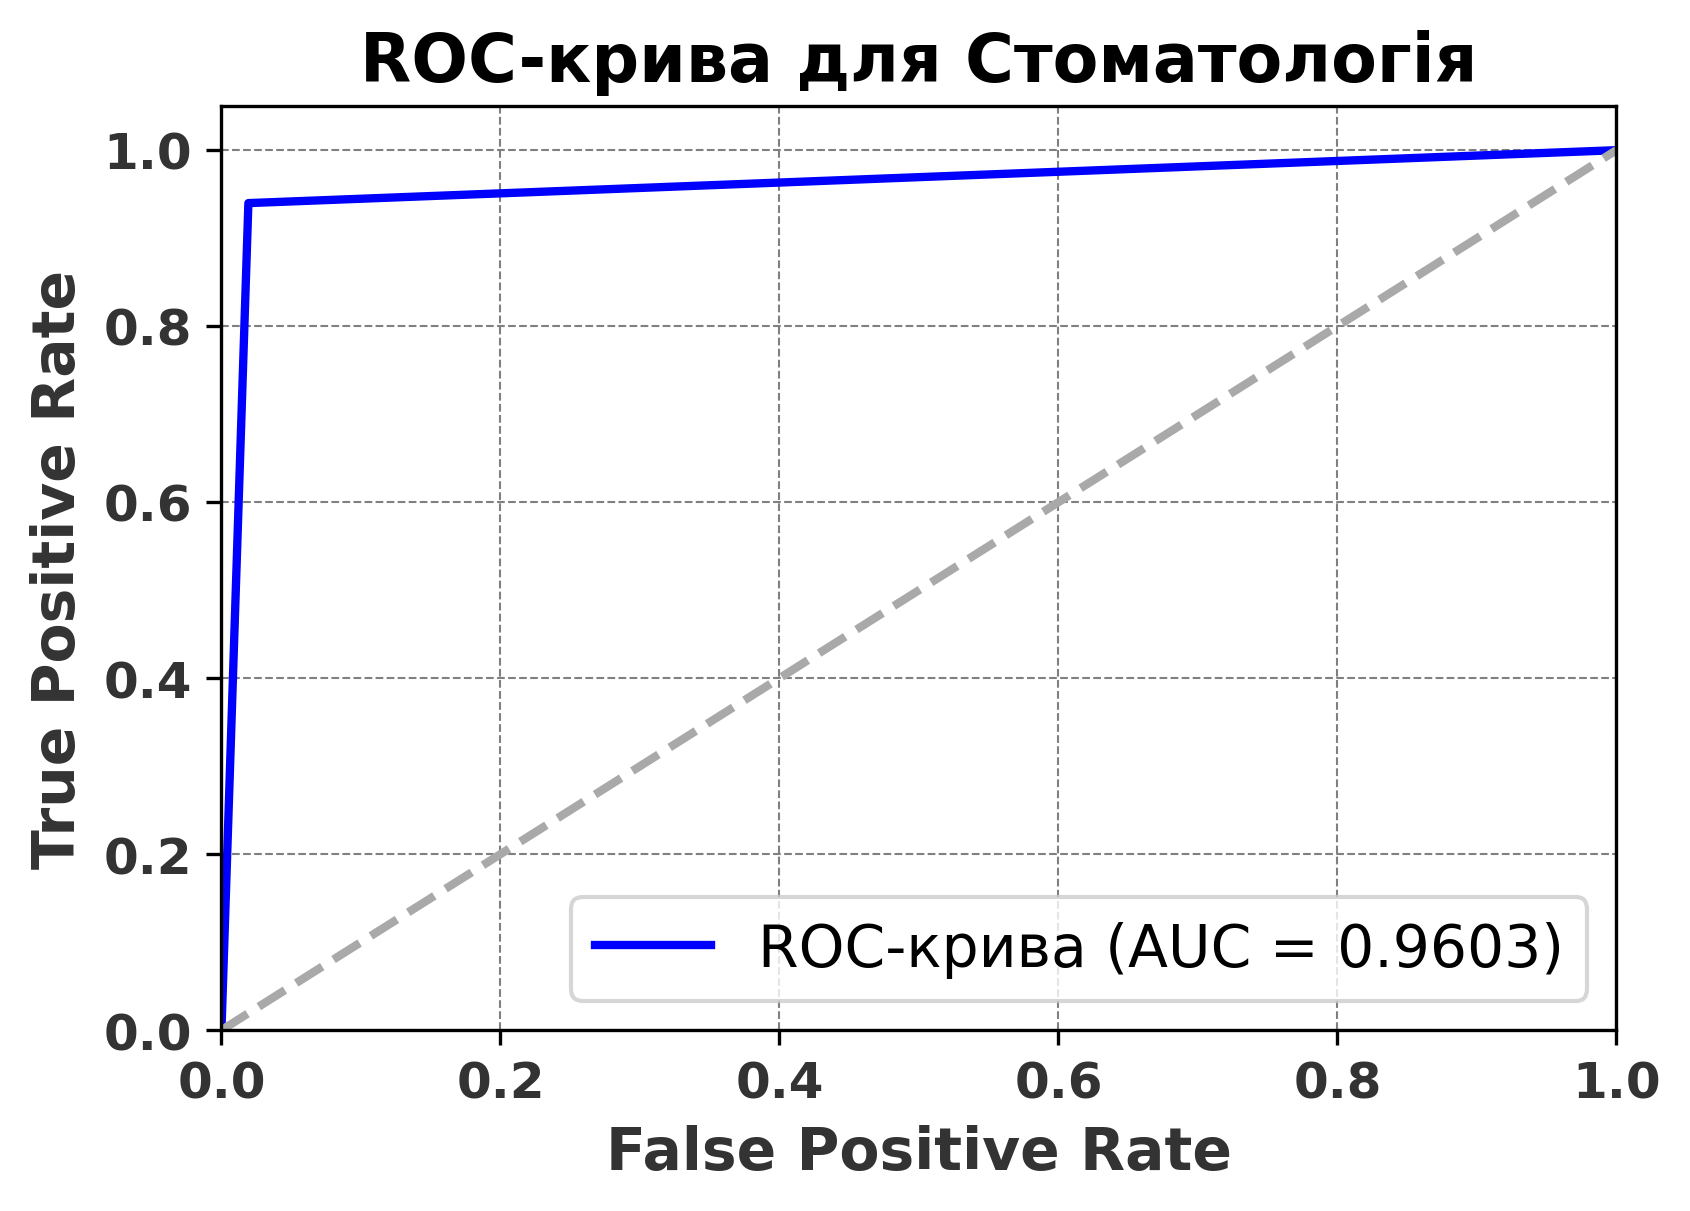

ROC curve for Стоматологія.csv plotted with AUC: 0.9603
Plot saved to ./projects_outscope/outscope_figs as Сурогатне


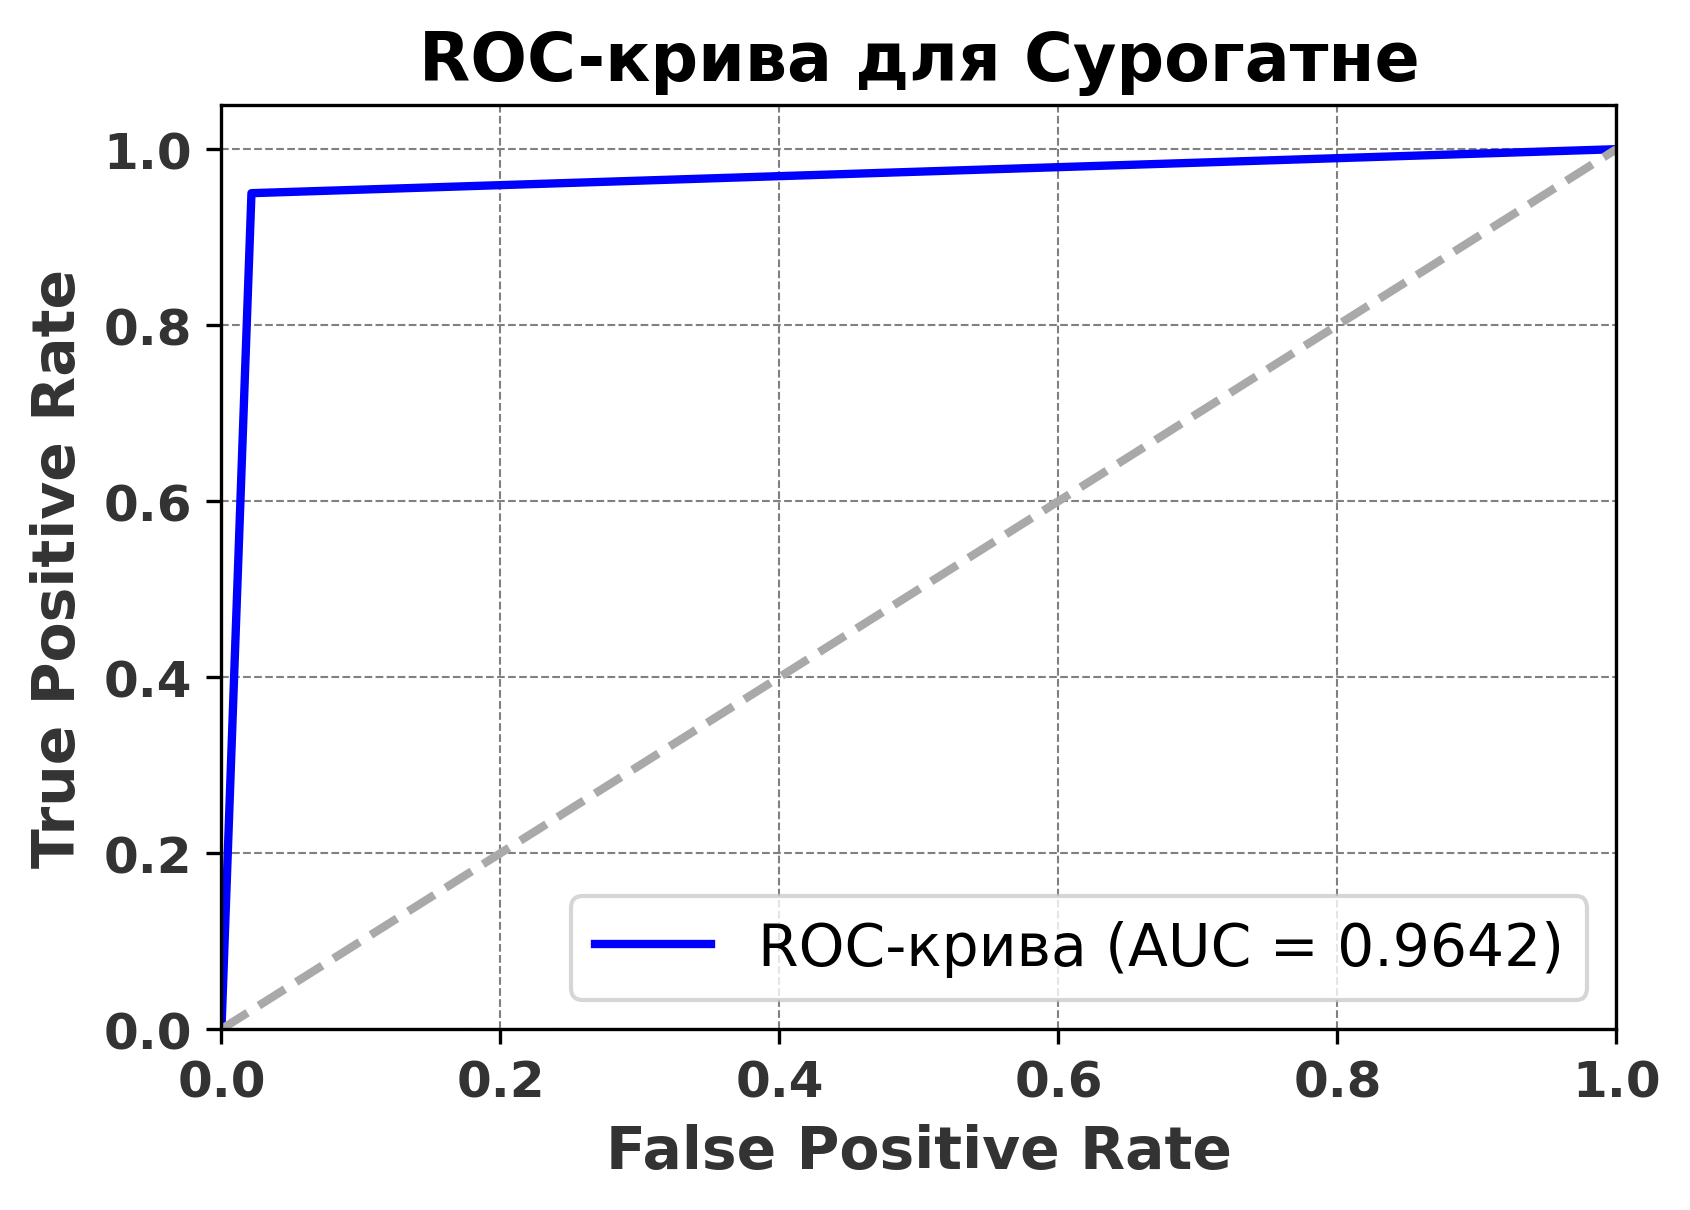

ROC curve for Сурогатне.csv plotted with AUC: 0.9642
Plot saved to ./projects_outscope/outscope_figs as Терапія


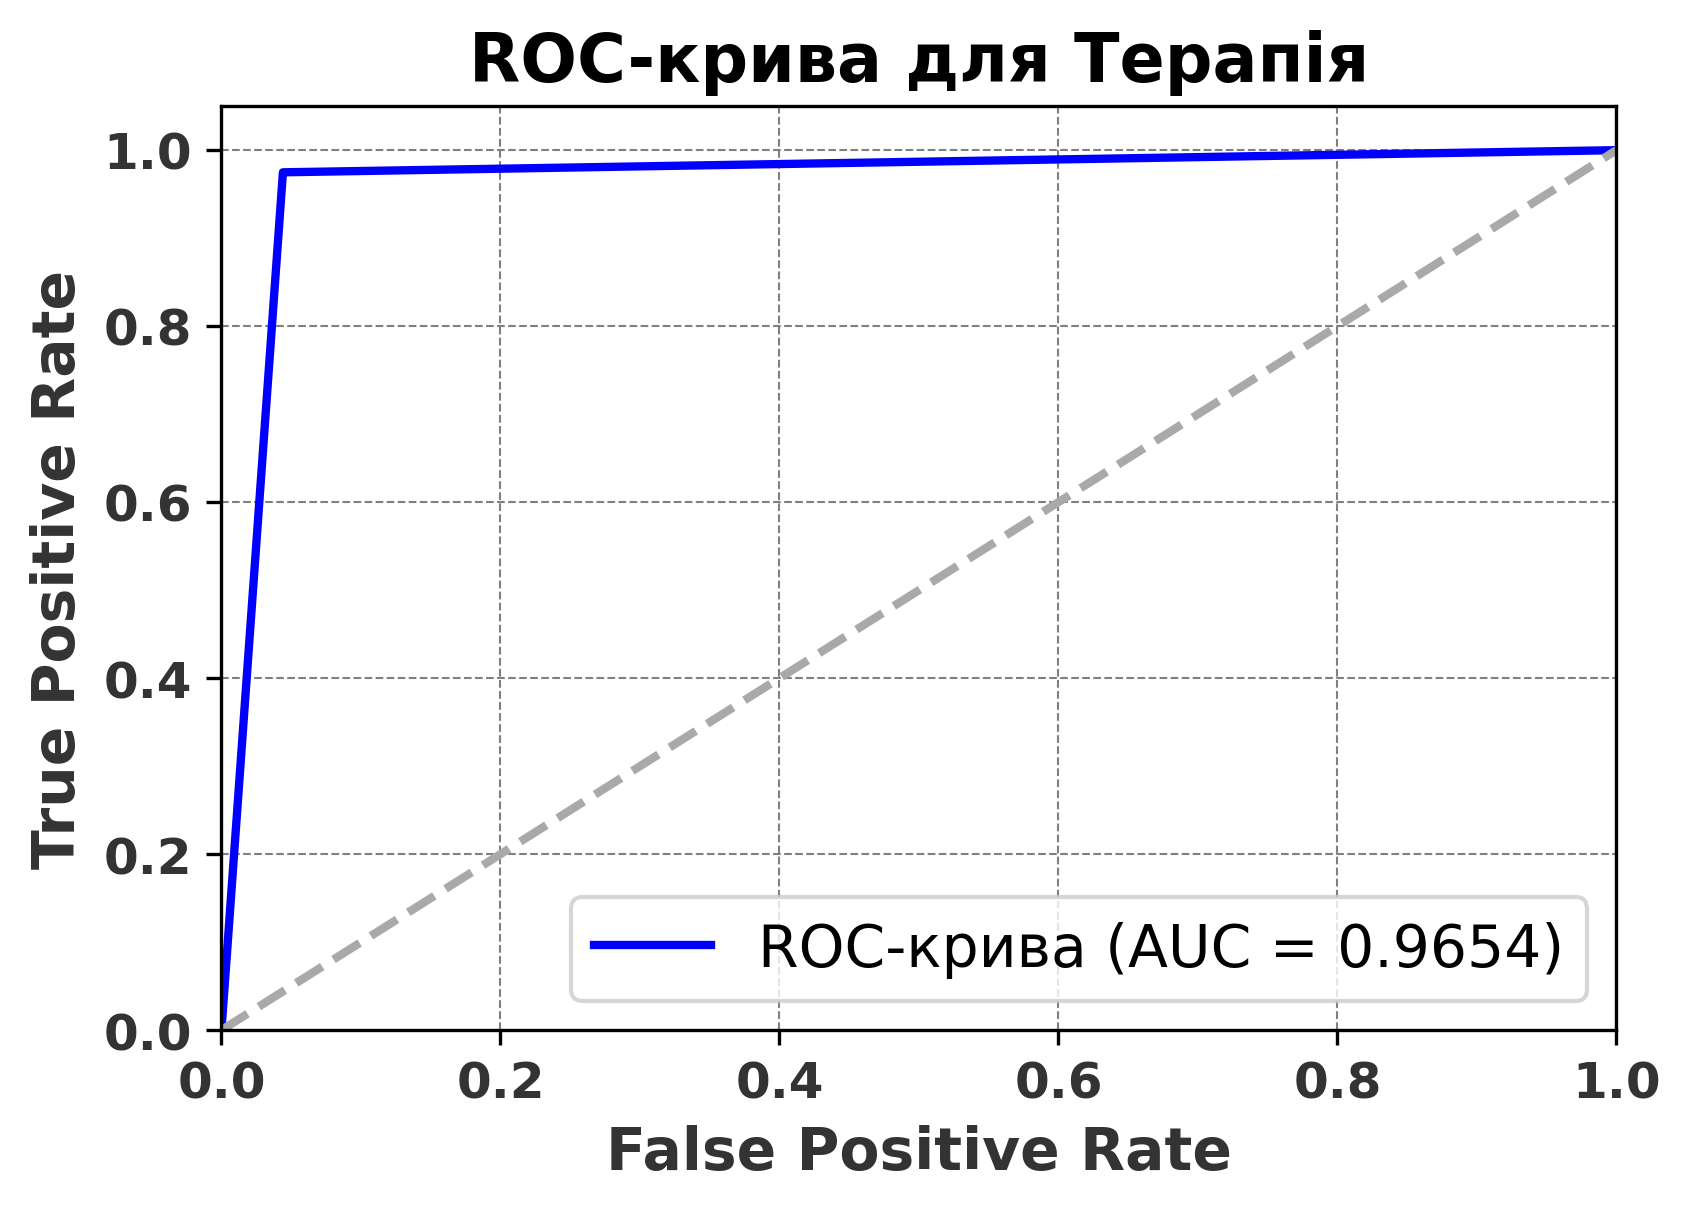

ROC curve for Терапія.csv plotted with AUC: 0.9654
Plot saved to ./projects_outscope/outscope_figs as Трансплантація


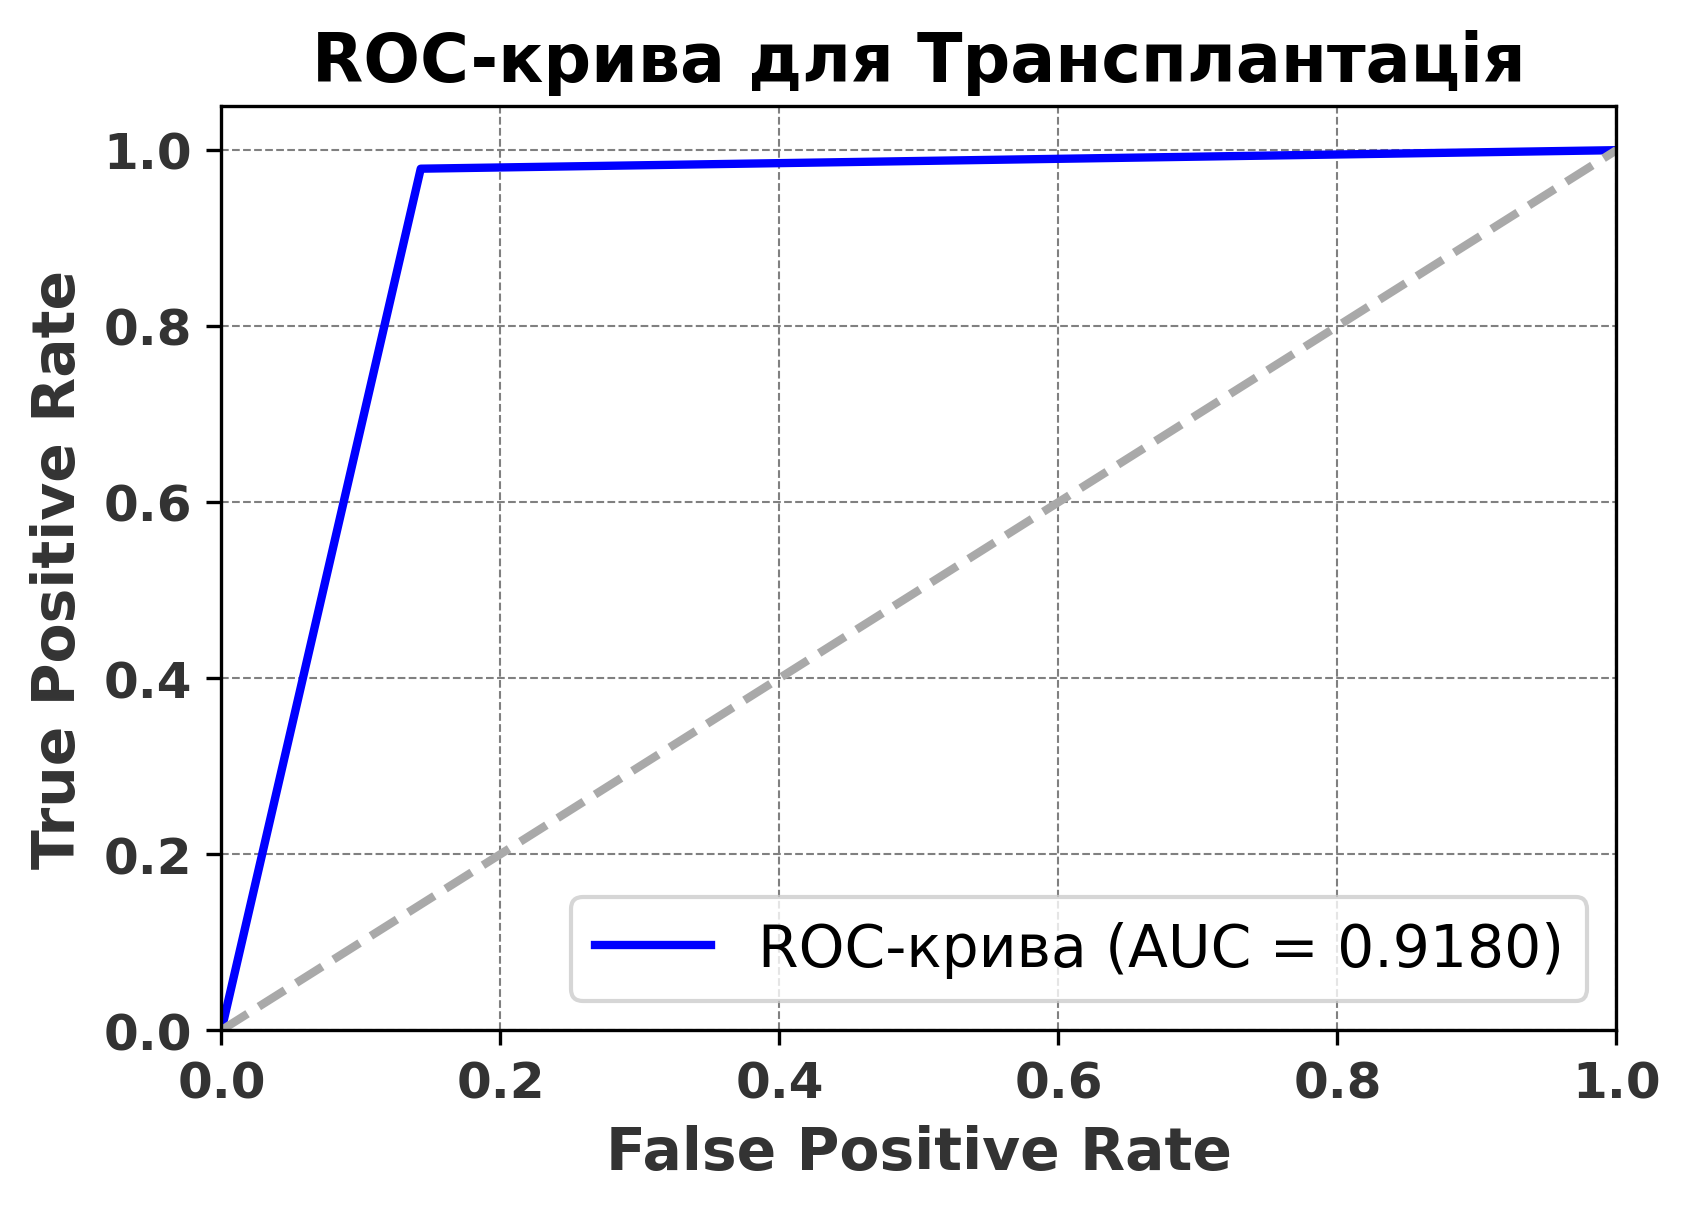

ROC curve for Трансплантація.csv plotted with AUC: 0.9180
All ROC curves have been plotted and saved.


In [11]:
# Define the input and output folder paths
input_folder_csv = './projects_outscope/outscope_csv'
output_folder_figs = './projects_outscope/outscope_figs'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder_figs):
    os.makedirs(output_folder_figs)

# Loop through each CSV file in the input folder
for file in os.listdir(input_folder_csv):
    if file.endswith('.csv'):
        file_path = os.path.join(input_folder_csv, file)
        df = pd.read_csv(file_path)

        # Check if the required columns are in the DataFrame
        if 'y_test' not in df.columns or 'y_pred' not in df.columns:
            print(f"Skipping file {file} as it does not contain 'y_test' and/or 'y_pred' columns.")
            continue

        y_test = df['y_test']
        y_pred = df['y_pred']

        figure_name = file.replace('.csv', '')
        auc_score = plot_roc_skl_binary(y_test, y_pred, output_folder_figs, figure_name)

        print(f'ROC curve for {file} plotted with AUC: {auc_score:.4f}')

print("All ROC curves have been plotted and saved.")
